In [1]:
# AETZ model replication using pytorch

import torch
from torch import nn
import numpy as np
import aet_net
import aet_dyn
from sklearn.manifold import TSNE

# get CUDA index
DEVICE = torch.cuda.current_device()

import matplotlib.pyplot as plt
from itertools import combinations


plt.rcParams["figure.figsize"] = (15,5)

In [2]:
# initialize model
nn_dim_ = [28,64,4]
eta_ = 0.1
mini_sz_ = 1
num_epo_ = 50
kl_reg_ = []#[0,0.001]
sig_param = [2, -2.5]

#lossfun = [nn.BCELoss(), nn.Sigmoid()]
lossfun = [aet_net.CE_loss, nn.Softmax(dim=0)]
params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param


model = aet_net.net(params,lossfun)
model = model.to(DEVICE)

epoch: 0, cumulative loss: 22.188426971435547
epoch: 1, cumulative loss: 22.142223358154297
epoch: 2, cumulative loss: 22.088335037231445
epoch: 3, cumulative loss: 21.931947708129883
epoch: 4, cumulative loss: 21.359655380249023
epoch: 5, cumulative loss: 20.237333297729492
epoch: 6, cumulative loss: 18.552339553833008
epoch: 7, cumulative loss: 15.790568351745605
epoch: 8, cumulative loss: 11.600841522216797
epoch: 9, cumulative loss: 9.326353073120117
epoch: 10, cumulative loss: 8.587450981140137
epoch: 11, cumulative loss: 4.930145740509033
epoch: 12, cumulative loss: 2.906558036804199
epoch: 13, cumulative loss: 1.6343426704406738
epoch: 14, cumulative loss: 1.165056824684143
epoch: 15, cumulative loss: 0.8875816464424133
epoch: 16, cumulative loss: 0.7189592123031616
epoch: 17, cumulative loss: 0.6081366539001465
epoch: 18, cumulative loss: 0.5282357931137085
epoch: 19, cumulative loss: 0.4670941233634949
epoch: 20, cumulative loss: 0.41850578784942627
epoch: 21, cumulative loss:

Text(0.5, 0, 'epoch')

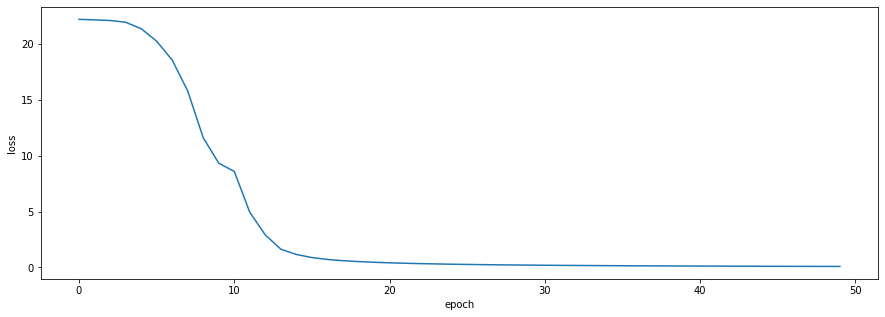

In [3]:
# train model
optimizer = torch.optim.SGD(model.parameters(),lr=eta_)

loss_hist = model.train(optimizer,noise=False)
plt.plot(np.arange(model.num_ep),loss_hist.cpu().detach().numpy())
plt.ylabel('loss')
plt.xlabel('epoch')

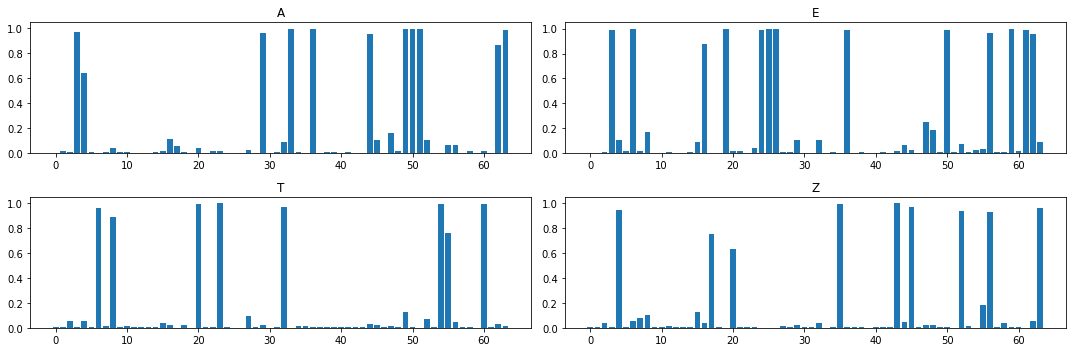

In [4]:
x_train, y_train = aet_net.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# subset of inputs
idx = np.array((0,5,10,-1))
data_sub = x_train[idx]
label = ['A','E','T','Z']


fig, axs = plt.subplots(2,2)
axs = axs.ravel()

for i,ax in enumerate(axs):
    Z,H,O = model.forw_conv(data_sub[i])
    
    ax.bar(np.arange(model.dims[1]),H.cpu().detach().numpy())
    ax.set_title(label[i])
    
fig.tight_layout()

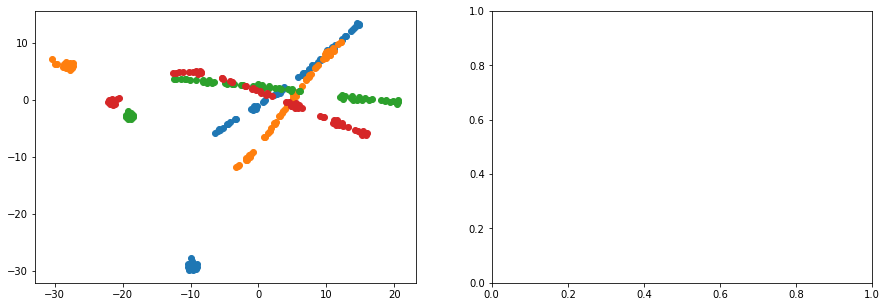

In [5]:
# TSNE visualization

fig, ax = plt.subplots(1,2)
for i,data in enumerate(data_sub):
    
    H = model.forw_conv(data)[1].detach().cpu().numpy()
    H_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10).fit_transform(H.reshape(-1,1))
    ax[0].scatter(H_embedded[:,0],H_embedded[:,1])


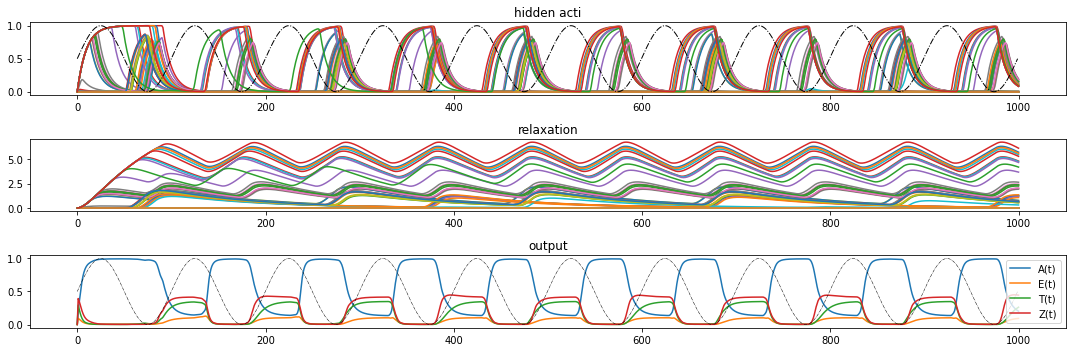

In [6]:
# dynamics
alpha_params = [10,0.5]
dyn_params = [0.01,0.1,2,0.05,0,0]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

timevec = np.linspace(0,1,1000)

Z_t,H_t, R_t, O_t  = aet_dyn.euler_dyn(model,x_train[0], dyn_params, timevec, alpha_params,DEVICE)

fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')

if alpha_params[1]:
    alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
    ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()



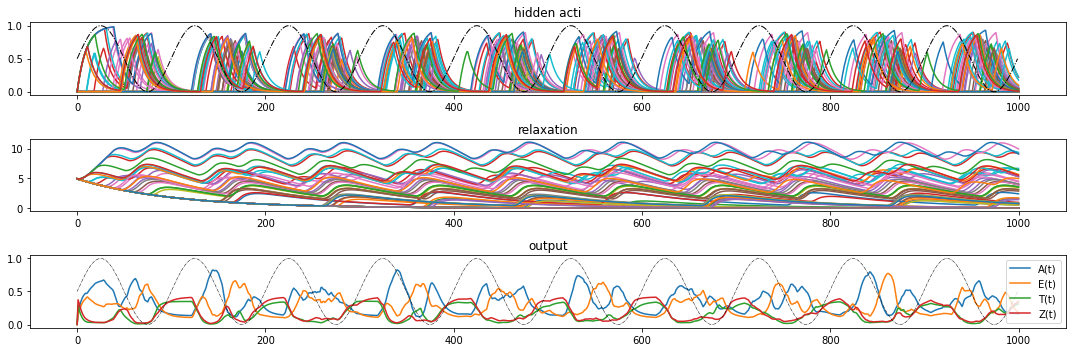

In [7]:
# competing inputs + dynamics
alpha_params = [10,0.7]
dyn_params = [0.01,0.1,2.5,0.01,0,0.5]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

timevec = np.linspace(0,1,1000)
inp_combi = list(combinations(idx,2))           # possible combinations

input_ = x_train[inp_combi[0][0]] *1.1+ x_train[inp_combi[0][1]]*0.9
Z_t,H_t, R_t, O_t  = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE)

fig,ax = plt.subplots(3,1)
ax[2].plot(O_t.T.cpu().detach().numpy())
ax[2].legend(('A(t)','E(t)','T(t)','Z(t)'),loc='lower right')
ax[2].set_title('output')

ax[1].plot(R_t.T.cpu().detach().numpy())
ax[1].set_title('relaxation')
ax[0].plot(H_t.T.cpu().detach().numpy())
ax[0].set_title('hidden acti')

if alpha_params[1]:
    alpha_inh = 0.5*np.sin(2*np.pi*timevec*10)+0.5
    ax[2].plot(alpha_inh,'k',linewidth=0.5,linestyle='-.')
    ax[0].plot(alpha_inh,'k',linewidth=1,linestyle='-.')
fig.tight_layout()

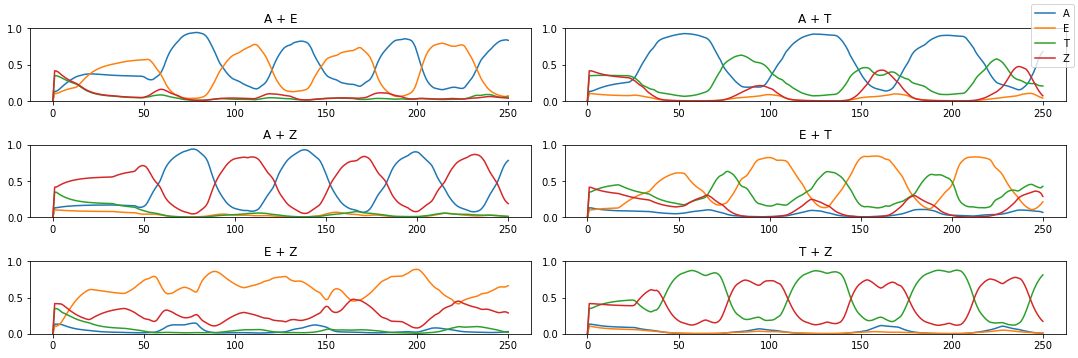

In [8]:
# all combinations#
alpha_params = [10,0]
dyn_params = [0.01,0.1,1.5,0.05,0,1]   # [tau_h, tau_r, r_scale factor, T, h start, R start]

timevec = np.linspace(0,0.25,250)
fig,ax = plt.subplots(3,2)
ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))
for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *1.1+ x_train[comp_inp[1]]*0.9
    _,_,_,O_t = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE)
    
    ax[i].plot(O_t.cpu().detach().numpy().T)
    ax[i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[0])[0][0], np.where(idx == comp_inp[1])[0][0]]
    ax[i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
fig.legend((label))
fig.tight_layout()

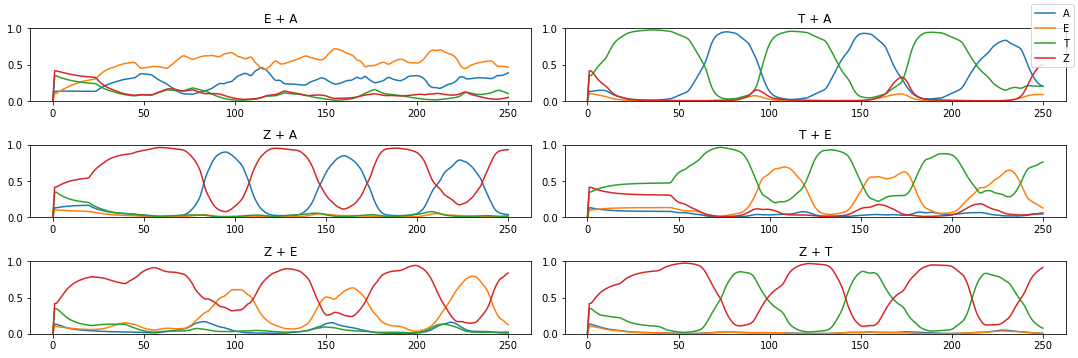

In [9]:
fig,ax = plt.subplots(3,2)
ax = ax.ravel()
plt.setp(ax,yticks=np.arange(0,1.5,0.5))
for i,comp_inp in enumerate(inp_combi):
    input_ = x_train[comp_inp[0]] *0.9+ x_train[comp_inp[1]]*1.1
    _,_,_,O_t = aet_dyn.euler_dyn(model,input_, dyn_params, timevec, alpha_params,DEVICE)
    
    ax[i].plot(O_t.cpu().detach().numpy().T)
    ax[i].set_ylim((0,1))
    fi = [np.where(idx == comp_inp[1])[0][0], np.where(idx == comp_inp[0])[0][0]]
    ax[i].set_title(label[fi[0]] + ' + ' + label[fi[1]])
fig.legend((label))
fig.tight_layout()